**Jason Stranne, Aayush Goradia, Nathan Parikh**

# Imports and Data Wrangling

In [ ]:
! pip install -q kaggle

### Upload your kaggle key (necessary for easy download)

Instructions to get your key:
**Authentication**
In order to use the Kaggle’s public API, you must first authenticate using an API token. From the site header, click on your user profile picture, then on “My Account” from the dropdown menu. This will take you to your account settings at https://www.kaggle.com/account. Scroll down to the section of the page labelled API:

To create a new token, click on the “Create New API Token” button. This will download a fresh authentication token onto your machine.

**Upload the kaggle.json file**

In [ ]:
 from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d andrewmvd/covid19-ct-scans


 98% 1.01G/1.03G [01:00<00:02, 10.2MB/s]
100% 1.03G/1.03G [01:00<00:00, 18.3MB/s]


## Unzip the data

In [ ]:
! unzip covid19-ct-scans.zip

Archive:  covid19-ct-scans.zip
  inflating: ct_scans/coronacases_org_001.nii  
  inflating: ct_scans/coronacases_org_002.nii  
  inflating: ct_scans/coronacases_org_003.nii  
  inflating: ct_scans/coronacases_org_004.nii  
  inflating: ct_scans/coronacases_org_005.nii  
  inflating: ct_scans/coronacases_org_006.nii  
  inflating: ct_scans/coronacases_org_007.nii  
  inflating: ct_scans/coronacases_org_008.nii  
  inflating: ct_scans/coronacases_org_009.nii  
  inflating: ct_scans/coronacases_org_010.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm.nii  
  inflating: ct_scans

In [ ]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt

In [ ]:
# Read and examine metadata
data = pd.read_csv('metadata.csv')
data['ct_scan'] = data['ct_scan'].str[26:]
data['lung_mask'] = data['lung_mask'].str[26:]
data['infection_mask'] = data['infection_mask'].str[26:]
data['lung_and_infection_mask'] = data['lung_and_infection_mask'].str[26:]

data.sample(2)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
9,ct_scans/coronacases_org_010.nii,lung_mask/coronacases_010.nii,infection_mask/coronacases_010.nii,lung_and_infection_mask/coronacases_010.nii
8,ct_scans/coronacases_org_009.nii,lung_mask/coronacases_009.nii,infection_mask/coronacases_009.nii,lung_and_infection_mask/coronacases_009.nii


In [ ]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

# Sample Data

In [ ]:
# Read sample
sample_ct   = read_nii(data.loc[1,'ct_scan'])
sample_lung = read_nii(data.loc[1,'lung_mask'])
sample_infe = read_nii(data.loc[1,'infection_mask'])
sample_all  = read_nii(data.loc[1,'lung_and_infection_mask'])

Text(0.5, 1.0, 'Lung and Infection Mask')

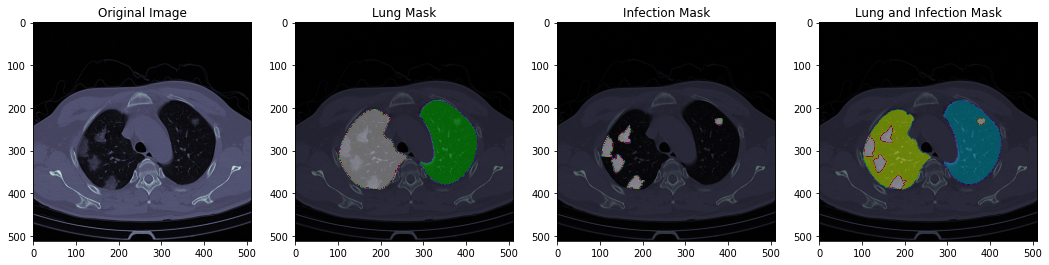

In [ ]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_lung[..., 150],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask')

plt.subplot(1,4,3)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_infe[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask')

plt.subplot(1,4,4)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_all[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung and Infection Mask')

In [ ]:
ct = read_nii(data['ct_scan'][0])
print(ct.shape)

(512, 512, 301)


In [ ]:
lungs = []
infections = []
groups = []
img_size = 256
import cv2
from tqdm import tqdm_notebook

total_count = 0
for i in tqdm_notebook(range(len(data))):
    ct = read_nii(data['ct_scan'][i])
    infect = read_nii(data['infection_mask'][i])
    
    init_count = total_count
    print(ct.shape)
    
    for ii in range(ct.shape[-1]):
        
        if ii==0:
            print(ct[..., ii].shape)
        
        lung_img = cv2.resize(ct[...,ii], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        infec_img = cv2.resize(infect[...,ii],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        
#         lung_img = np.array(ct[...,ii])
#         infec_img = np.array(infect[...,ii])
        
        lungs.append(lung_img[..., np.newaxis])
        infections.append(infec_img[..., np.newaxis])
        groups.append(i)
        total_count += 1
    
    print(f"patient {i} ranges from {init_count} to {total_count-1}")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


(512, 512, 301)
(512, 512)
patient 0 ranges from 0 to 300
(512, 512, 200)
(512, 512)
patient 1 ranges from 301 to 500
(512, 512, 200)
(512, 512)
patient 2 ranges from 501 to 700
(512, 512, 270)
(512, 512)
patient 3 ranges from 701 to 970
(512, 512, 290)
(512, 512)
patient 4 ranges from 971 to 1260
(512, 512, 213)
(512, 512)
patient 5 ranges from 1261 to 1473
(512, 512, 249)
(512, 512)
patient 6 ranges from 1474 to 1722
(512, 512, 301)
(512, 512)
patient 7 ranges from 1723 to 2023
(512, 512, 256)
(512, 512)
patient 8 ranges from 2024 to 2279
(512, 512, 301)
(512, 512)
patient 9 ranges from 2280 to 2580
(630, 630, 39)
(630, 630)
patient 10 ranges from 2581 to 2619
(630, 630, 418)
(630, 630)
patient 11 ranges from 2620 to 3037
(401, 630, 110)
(401, 630)
patient 12 ranges from 3038 to 3147
(630, 630, 66)
(630, 630)
patient 13 ranges from 3148 to 3213
(630, 630, 42)
(630, 630)
patient 14 ranges from 3214 to 3255
(630, 630, 42)
(630, 630)
patient 15 ranges from 3256 to 3297
(630, 630, 45)
(6

## Read into numpy array and normalize

In [ ]:
lungs = np.array(lungs)/255.0
infections = np.array(infections)
groups = np.array(groups)

print(lungs.shape)
print(infections.shape)
print(groups.shape)

(3520, 256, 256, 1)
(3520, 256, 256, 1)
(3520,)


## Graph a sample image

1524


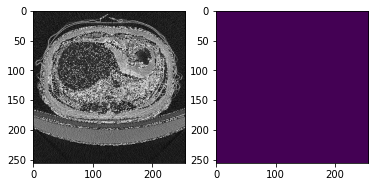

In [ ]:
import random
index = random.randint(0, len(lungs)-1)
print(index) # 10971 is a good one, 9564 is better
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].imshow(lungs[index][:, :, 0], cmap=plt.cm.gray)
axs[1].imshow(lungs[index][:, :, 0], cmap=plt.cm.gray)
axs[1].imshow(infections[index][:, :, 0])

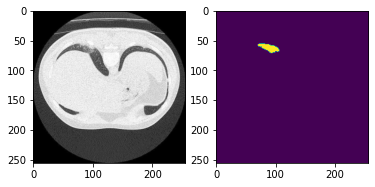

In [ ]:
index = 2700
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].imshow(lungs[index][:, :, 0], cmap=plt.cm.gray)
axs[1].imshow(lungs[index][:, :, 0], cmap=plt.cm.gray)
axs[1].imshow(infections[index][:, :, 0])

# Split Data

In [ ]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(lungs, infections, groups)
from sklearn.utils import shuffle



train_index, test_index = group_kfold.split(lungs, infections, groups).__next__()
lung_train, lung_test = lungs[train_index], lungs[test_index]
infect_train, infect_test = infections[train_index], infections[test_index]

# # lets also shuffle the data
lung_train, infect_train = shuffle(lung_train, infect_train, random_state=0)
lung_test, infect_test = shuffle(lung_test, infect_test, random_state=0)

print(f"leaving out {np.unique(groups[test_index])}")



leaving out [ 2 10 11 16]


2818
(2818, 256, 256, 1)
702
(702, 256, 256, 1)
[[0.0745098  0.19215686 0.10196078 ... 0.12156863 0.1372549  0.11372549]
 [0.15294118 0.06666667 0.0745098  ... 0.11764706 0.09019608 0.17254902]
 [0.10588235 0.05490196 0.07058824 ... 0.18823529 0.16862745 0.12941176]
 ...
 [0.08235294 0.17254902 0.18039216 ... 0.14509804 0.12156863 0.07843137]
 [0.25098039 0.16078431 0.15294118 ... 0.05490196 0.2        0.18039216]
 [0.05882353 0.13333333 0.23529412 ... 0.15686275 0.08627451 0.15686275]]
<class 'numpy.ndarray'>
(256, 256)


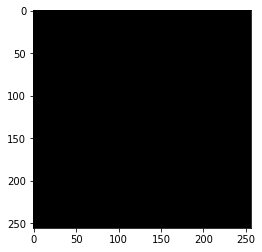

In [ ]:
print(len(infect_train))
print(np.shape(infect_train))
print(len(infect_test))
print(np.shape(infect_test))
plt.imshow(infect_train[150][:, :, 0], cmap='bone')
img = lung_train[150][:,:,0]
img2 = infect_train[150][:,:,0]
print(img)
print(type(img))
print(np.shape(img))
#plt.imsave(('/content/gdrive/My Drive/BME_548_data_new/' + str(150) + '.png'), img, cmap ='bone')

# U-Net and HR-Net


## Losses

In [ ]:
import numpy as np
from keras import backend as K
import tensorflow as tf

import dill


def binary_focal_loss(gamma=2., alpha=0.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    def loss(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        # y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1 - p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.mean(K.sum(loss, axis=1))
        return loss

    return loss

In [ ]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
  #print("start")
  intersection = K.sum(tf.cast(y_true, tf.float32) * y_pred, axis=[1,2])
  #print("mid")
  union = K.sum(tf.cast(y_true, tf.float32), axis=[1,2]) + K.sum(y_pred, axis=[1,2])

  #print("ok")
  return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss():
  def dice_p_bce(in_gt, in_pred):
    loss = 10.0*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
    return loss
  return dice_p_bce

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)


def weight_loss(column_weights):
    global temp
    n = 64.0
    return 0.5*tf.keras.losses.mean_squared_error(n, sum_w_prime(column_weights, temp))


def dice_loss_weight_decay():
  def dice_p_bce_weight(in_gt, in_pred, column_weight_vals, temp_val):
    global column_weights
    loss = 3.0*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred) + 0.5* K.square(tf.math.reduce_sum(tf.math.sigmoid(temp_val*column_weights))-128.0)
    return loss
  return dice_p_bce_weight

## Metrics

In [ ]:
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def decimal_IOU(y_true, y_pred, smooth=0.001):
    #print("start")
    intersection = K.sum(tf.cast(y_true, tf.float32) * y_pred, axis=[1,2])
    #print("mid")
    union = K.sum(tf.cast(y_true, tf.float32), axis=[1,2]) + K.sum(y_pred, axis=[1,2])

    return K.mean( (intersection + smooth) / (union + smooth - intersection), axis=0)

# Physical Layer Variable

In [ ]:
def reset_physical_layer(trainable=True):
    global temp
    temp = 0.1

    global column_weights
    NUM_SAMPLES = 64
    NUM_COLUMNS = 256
    if trainable:
        #logits_train = tf.Variable(initial_value=tf.ones(shape=(NUM_SAMPLES, NUM_COLUMNS)), dtype='float32' ,trainable=True)
        column_weights = tf.Variable(initial_value=tf.random.normal(shape=(1, NUM_COLUMNS), mean=0.0, stddev=0.1), dtype='float32' ,trainable=True)
    else:
        logits = np.ones((1, NUM_COLUMNS))*-100
        logits[:, ::2] = 100
        logits[:,0] = 100
        column_weights = tf.Variable(initial_value=logits, dtype='float32' ,trainable=False)


In [ ]:
def visualize_physical_layer(temperature=5):
    global column_weights

    NUM_COLUMNS = 256
    # #visualize the most likely selection

    column_to_mult = scale_anneal(column_weights, temperature).numpy()

    plot = np.stack([column_to_mult]*NUM_COLUMNS, axis=0)


    plt.figure(figsize=(10,10))
    plt.imshow(plot[:, 0, :])
    plt.colorbar(fraction=0.045, pad=0.05)
    plt.title("Mask", fontsize=18)
    plt.axis('off')


def visualize_physical_layer_fourier(test_img, temperature=5):
    global column_weights

    NUM_COLUMNS = 256
    column_to_mult = scale_anneal(column_weights, temperature).numpy()
    plot = np.stack([column_to_mult]*NUM_COLUMNS, axis=0)

    print(test_img.shape)
     
    FT_image = tf.abs(tf.signal.fftshift(tf.signal.fft2d(test_img[:, :, :, 0]), axes=(1,2)))
    print(FT_image.shape)

    plt.figure(figsize=(10,10))
    plt.imshow(np.log(FT_image[0, :, :]), cmap='YlGn')
    plt.imshow(plot[:, 0, :], alpha=0.4, cmap='Reds')
    plt.axhline(color='black', lw=0.5, xmin=128)
    plt.axvline(color='black', lw=0.5)
    plt.colorbar()

def visualize_logits():
    global logits_train
    plt.figure(figsize=(10,10))
    plt.imshow(logits_train.value())
    plt.colorbar()

tf.Tensor(127.445496, shape=(), dtype=float32)


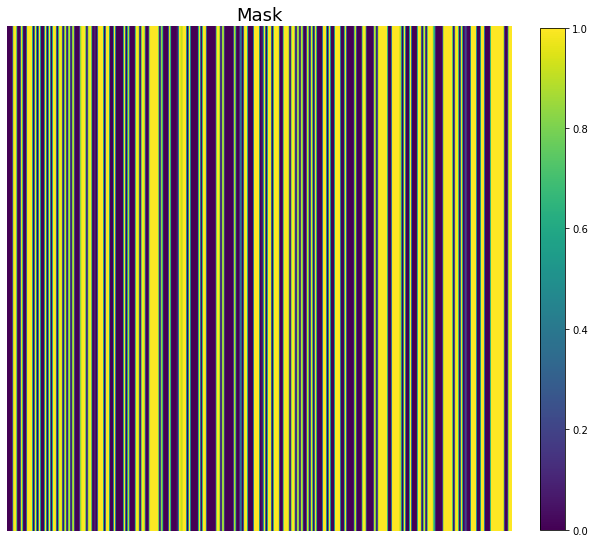

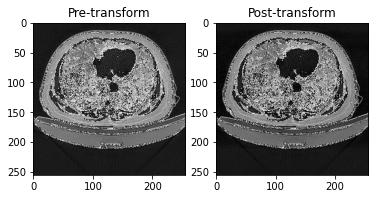

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras.backend as K


def sum_w_prime(weights, temp_val):
    s = tf.math.reduce_sum(tf.math.sigmoid(weights*temp_val))
    return s


def scale_anneal(weights, temp_val):
    return tf.math.sigmoid(weights*temp_val)


def physical_layer(x_batch, temp_val=1.0):
    global column_weights
    global temp

    x_batch = tf.cast(x_batch[:,:,:,0], dtype=tf.complex64)
    FT_image = tf.signal.fftshift(tf.signal.fft2d(x_batch), axes=(1,2))

    
    w_prime = scale_anneal(column_weights, temp_val)

    sampled_four = tf.math.multiply(FT_image, tf.cast(w_prime, dtype=tf.complex64), name=None)

    new_image = tf.signal.ifft2d(tf.signal.fftshift(sampled_four, axes=(1,2)))
    new_image = tf.abs(new_image)

    new_image = new_image[...,tf.newaxis]

    return new_image


reset_physical_layer(True)
visualize_physical_layer(temperature)

# Make sure it's working
phys_layer_test1 = physical_layer(lung_train[0:5,:,:,:])
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
axs[0].imshow(lung_train[4][:,:,0], cmap=plt.cm.gray)
axs[0].set_title("Pre-transform")
axs[1].imshow(phys_layer_test1[4][:,:,0], cmap=plt.cm.gray)
axs[1].set_title("Post-transform")

global column_weights
global temp
print(sum_w_prime(column_weights, 2.0))

# U-Net

## U-Net Model Definition

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, Dropout
import tensorflow as tf

def create_Unet(input_shape, num_classes):
    input_layer = Input(input_shape)
    x = input_layer
    # down path
    start_filters = 32
    skip_list=[]

    skips=4

    for i in range(skips):
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        skip_list.append(x)
        x = MaxPool2D()(x)
        x = Dropout(0.5)(x)
    # bottleneck
    x = Conv2D(start_filters*(2**3),skips, padding='same', activation='relu')(x) #7th
    x = Conv2D(start_filters*(2**3),skips, padding='same', activation='relu')(x)
    # up path
    for i in range(skips):
        x = UpSampling2D()(x)
        x = tf.concat([skip_list[-(i+1)], x], axis=-1)
        x = Dropout(0.5)(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
    # output = Conv2D(num_classes, 1, activation='softmax')(x)
    output = Conv2D(num_classes, 1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model


In [ ]:
unet_model = create_Unet([256, 256, 1], 1)
unet_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

## U-Net Iterative Learning

In [ ]:
optimize_physical_layer = True #@param {type:"boolean"}


train_ds = tf.data.Dataset.from_tensor_slices((lung_train, infect_train)).shuffle(10000).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((lung_test, infect_test)).batch(16)


global column_weights
global temp




temperature=0.5


reset_layer = True #@param {type:"boolean"}
if reset_layer:
    reset_physical_layer(optimize_physical_layer)

reset_model = True #@param {type:"boolean"}
if reset_model:
    unet_model = create_Unet([256, 256, 1], 1)

# Make sure to reset "unet_FT_multiplier" to whatever pre-initialized variable you are testing
def forward_model(x_batch, temp_val):
  p_layer_out = physical_layer(x_batch, temp_val)
  return unet_model(p_layer_out)


loss_object = dice_loss_weight_decay()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy', threshold=0.5)

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy', threshold=0.5)

# train loop
@tf.function
def train_step(images, labels, column_weights, temperature):
  with tf.GradientTape(persistent=True) as tape:
    predictions = forward_model(images, temperature)
    loss = loss_object(labels, predictions, column_weights, temperature)

  if optimize_physical_layer:
    training_variables = [column_weights] + unet_model.trainable_variables
  else:
    training_variables = unet_model.trainable_variables
  gradients = tape.gradient(loss, training_variables)
  optimizer.apply_gradients(zip(gradients, training_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)
  return dice_coef(labels, predictions), decimal_IOU(labels, predictions)

@tf.function
def test_step(images, labels, column_weights, temperature):
  predictions = forward_model(images, temperature)
  t_loss = loss_object(labels, predictions, column_weights, temperature)
  ## If you add a print statement here, for some reason, only prints at first epoch
  test_loss(t_loss)
  test_accuracy(labels, predictions)
  return dice_coef(labels, predictions), decimal_IOU(labels, predictions)

EPOCHS = 60 

for epoch in range(EPOCHS):

  if epoch>10:
    temperature+=1
  if epoch>20:
      temperature+=3
  if epoch>35:
      temperature+=5
  if epoch>45:
      temperature+=20

  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  print(f"weight sum is {sum_w_prime(column_weights, temperature).numpy()} with temperature {temperature}")


  for images, labels in train_ds:

    train_dice_coef, train_decimal_iou = train_step(images, labels, column_weights, temperature)

  for test_images, test_labels in test_ds:
    test_dice_coef, test_decimal_iou = test_step(test_images, test_labels, column_weights, temperature)

  print(
    f'Epoch {epoch + 1}, '
    f'loss: {train_loss.result()}, '
    f'dice_coef: {train_dice_coef[0]}, '
    f'decimal_IOU: {train_decimal_iou[0]}, '
    f'accuracy: {train_accuracy.result() * 100}, '
    f'test_loss: {test_loss.result()}, '
    f'test_dice_coef: {test_dice_coef[0]}, '
    f'test_decimal_iou: {test_decimal_iou[0]}, '
    f'test_accuracy: {test_accuracy.result() * 100}'
  )
  print(f"Temperature is {temperature}")

weight sum is 128.02980041503906 with temperature 0.5
Epoch 1, loss: 0.09692523628473282, dice_coef: 0.0027005686424672604, decimal_IOU: 1.2081878594472073e-05, accuracy: 98.81373596191406, test_loss: -0.009648198261857033, test_dice_coef: 0.3970479965209961, test_decimal_iou: 0.005505175329744816, test_accuracy: 99.12954711914062
Temperature is 0.5
weight sum is 127.99349212646484 with temperature 0.5
Epoch 2, loss: -0.17092861235141754, dice_coef: 0.24071364104747772, decimal_IOU: 0.0005745331873185933, accuracy: 99.26406860351562, test_loss: -0.017644215375185013, test_dice_coef: 0.3618476092815399, test_decimal_iou: 0.005799769423902035, test_accuracy: 99.12954711914062
Temperature is 0.5
weight sum is 128.00119018554688 with temperature 0.5
Epoch 3, loss: -0.1755414456129074, dice_coef: 0.49121975898742676, decimal_IOU: 0.025341030210256577, accuracy: 99.2640380859375, test_loss: -0.11194183677434921, test_dice_coef: 0.6299359202384949, test_decimal_iou: 0.16184385120868683, test_

**Visualize Learned Layer**

1700
weight sum is 127.99800872802734
values of weights
tf.Tensor(
[[1.02262223e-21 1.00000000e+00 3.59348566e-35 0.00000000e+00
  1.01587080e-13 9.99999881e-01 1.00000000e+00 1.10263184e-34
  1.00000000e+00 2.45409104e-34 5.87396755e-12 5.81467643e-12
  1.97205747e-22 1.00000000e+00 0.00000000e+00 1.66632808e-33
  1.00000000e+00 0.00000000e+00 0.00000000e+00 2.50295626e-23
  0.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 9.26565919e-29 0.00000000e+00
  1.07827018e-25 1.00000000e+00 1.00000000e+00 0.00000000e+00
  2.18442018e-20 0.00000000e+00 9.99999046e-01 9.40601615e-20
  1.00000000e+00 1.01701087e-04 1.16694653e-26 0.00000000e+00
  0.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.05152271e-23 2.62054406e-24 2.83757140e-06 1.00000000e+00
  6.36789035e-31 1.91146188e-09 1.97784983e-38 1.01862578e-17
  8.74129895e-18 0.00000000e+00 3.88755172e-04 1.00000000e+00
  1

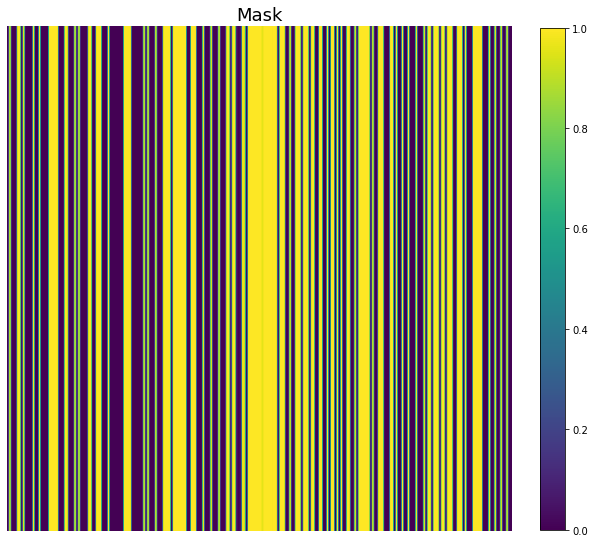

In [ ]:
#global column_weights
print(temperature)
print(f"weight sum is {sum_w_prime(column_weights, temperature).numpy()}")
visualize_physical_layer(temperature)
print("values of weights")

final_weights = scale_anneal(column_weights.numpy(), temperature)
print(final_weights)
print(np.sum(final_weights>0.1))

(1, 256, 256, 1)
(1, 256, 256)


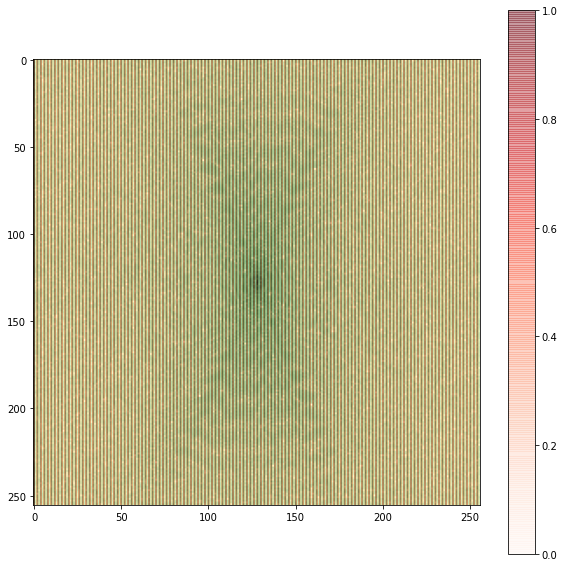

In [ ]:
visualize_physical_layer_fourier(lung_train[0:1, :, :, :], temperature)


1700


Text(0.5, 1.0, 'Post-transform')

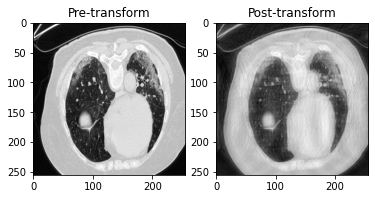

In [ ]:
print(temperature)
phys_layer_test = physical_layer(lung_train[0:25,:,:,:], temperature)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
axs[0].imshow(lung_train[10][:,:,0], cmap=plt.cm.gray)
axs[0].set_title("Pre-transform")
axs[1].imshow(phys_layer_test[10][:,:,0], cmap=plt.cm.gray)
axs[1].set_title("Post-transform")

# HR-Net 

## HR-Net Model Definition

In [ ]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation
from keras.layers import UpSampling2D, add, concatenate


def conv3x3(x, out_filters, strides=(1, 1)):
    x = Conv2D(out_filters, 3, padding='same', strides=strides, use_bias=False, kernel_initializer='he_normal')(x)
    return x


def basic_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    x = conv3x3(input, out_filters, strides)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = conv3x3(x, out_filters)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def bottleneck_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    expansion = 4
    de_filters = int(out_filters / expansion)

    x = Conv2D(de_filters, 1, use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(de_filters, 3, strides=strides, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(out_filters, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def stem_net(input):
    x = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = bottleneck_Block(x, 256, with_conv_shortcut=True)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)

    return x


def transition_layer1(x, out_filters_list=[32, 64]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    return [x0, x1]


def make_branch1_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch1_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer1(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0 = add([x0_0, x0_1])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1 = add([x1_0, x1_1])
    return [x0, x1]


def transition_layer2(x, out_filters_list=[32, 64, 128]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    return [x0, x1, x2]


def make_branch2_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch2_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch2_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer2(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0 = add([x0_0, x0_1, x0_2])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1_2 = Conv2D(64, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x1_2 = BatchNormalization(axis=3)(x1_2)
    x1_2 = UpSampling2D(size=(2, 2))(x1_2)
    x1 = add([x1_0, x1_1, x1_2])

    x2_0 = Conv2D(32, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_0 = Activation('relu')(x2_0)
    x2_0 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x2_0)
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_1 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2_1 = BatchNormalization(axis=3)(x2_1)
    x2_2 = x[2]
    x2 = add([x2_0, x2_1, x2_2])
    return [x0, x1, x2]


def transition_layer3(x, out_filters_list=[32, 64, 128, 256]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv2D(out_filters_list[3], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x3 = BatchNormalization(axis=3)(x3)
    x3 = Activation('relu')(x3)

    return [x0, x1, x2, x3]


def make_branch3_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_3(x, out_filters=256):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer3(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0_3 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[3])
    x0_3 = BatchNormalization(axis=3)(x0_3)
    x0_3 = UpSampling2D(size=(8, 8))(x0_3)
    x0 = concatenate([x0_0, x0_1, x0_2, x0_3], axis=-1)
    return x0


def final_layer(x, classes=1):
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(classes, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('sigmoid', name='Classification')(x)
    return x


def seg_hrnet(batch_size, height, width, channel, classes):
    inputs = Input(batch_shape=(batch_size,) + (height, width, channel))
    print(np.shape(inputs))

    x = stem_net(inputs)
    print(np.shape(x))


    x = transition_layer1(x)
    x0 = make_branch1_0(x[0])
    x1 = make_branch1_1(x[1])
    x = fuse_layer1([x0, x1])

    x = transition_layer2(x)
    x0 = make_branch2_0(x[0])
    x1 = make_branch2_1(x[1])
    x2 = make_branch2_2(x[2])
    x = fuse_layer2([x0, x1, x2])

    x = transition_layer3(x)
    x0 = make_branch3_0(x[0])
    x1 = make_branch3_1(x[1])
    x2 = make_branch3_2(x[2])
    x3 = make_branch3_3(x[3])
    x = fuse_layer3([x0, x1, x2, x3])

    out = final_layer(x, classes=classes)

    model = Model(inputs=inputs, outputs=out)

    return model

In [ ]:
from keras.utils import plot_model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

hrnet_model = seg_hrnet(batch_size=None, height=256, width=256, channel=1, classes=1)
hrnet_model.summary()

#plot_model(model, to_file='seg_hrnet.png', show_shapes=True)

(None, 256, 256, 1)
(None, 128, 128, 256)
Model: "functional_189"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_96 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_2124 (Conv2D)            (None, 128, 128, 64) 576         input_96[0][0]                   
__________________________________________________________________________________________________
batch_normalization_395 (BatchN (None, 128, 128, 64) 256         conv2d_2124[0][0]                
__________________________________________________________________________________________________
activation_346 (Activation)     (None, 128, 128, 64) 0           batch_normalization_395[0][0]    
___________________________________________

## HR-Net Iterative Learning

In [ ]:
# train_ds = tf.data.Dataset.from_tensor_slices((lung_train, infect_train)).shuffle(10000).batch(16)
# test_ds = tf.data.Dataset.from_tensor_slices((lung_test, infect_test)).batch(16)
optimize_physical_layer = True #@param {type:"boolean"}

global column_weights
global temp

reset_layer = True #@param {type:"boolean"}
if reset_layer:
    reset_physical_layer(optimize_physical_layer)

temperature=0.5


reset_model = True #@param {type:"boolean"}
if reset_model:
    hrnet_model = seg_hrnet(batch_size=None, height=256, width=256, channel=1, classes=1)

# Make sure to reset "unet_FT_multiplier" to whatever pre-initialized variable you are testing
def forward_model(x_batch, temp_val):
  p_layer_out = physical_layer(x_batch, temp_val)
  return hrnet_model(p_layer_out)


loss_object = dice_loss_weight_decay()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy', threshold=0.5)

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy', threshold=0.5)

# train loop
@tf.function
def train_step(images, labels, column_weights, temperature):
  with tf.GradientTape(persistent=True) as tape:
    predictions = forward_model(images, temperature)
    loss = loss_object(labels, predictions, column_weights, temperature)


  if optimize_physical_layer:
    training_variables = [column_weights] + hrnet_model.trainable_variables
  else:
    training_variables = hrnet_model.trainable_variables

  gradients = tape.gradient(loss, training_variables)
  optimizer.apply_gradients(zip(gradients, training_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)
  return dice_coef(labels, predictions), decimal_IOU(labels, predictions)

@tf.function
def test_step(images, labels, column_weights, temperature):
  predictions = forward_model(images, temperature)
  t_loss = loss_object(labels, predictions, column_weights, temperature)
  ## If you add a print statement here, for some reason, only prints at first epoch
  test_loss(t_loss)
  test_accuracy(labels, predictions)
  return dice_coef(labels, predictions), decimal_IOU(labels, predictions)

EPOCHS = 60 # Change back to 25

for epoch in range(EPOCHS):

  if epoch>10:
    temperature+=1
  if epoch>20:
      temperature+=3
  if epoch>35:
      temperature+=5
  if epoch>45:
      temperature+=20
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  print(f"weight sum is {sum_w_prime(column_weights, temperature).numpy()} with temperature {temperature}")


  for images, labels in train_ds:
    # NEED TO FIGURE OUT HOW TO RETURN METRICS BASED ON ALL OF TRAIN_DS
    # NOT JUST LAST ITERATION
    train_dice_coef, train_decimal_iou = train_step(images, labels, column_weights, temperature)

  for test_images, test_labels in test_ds:
    test_dice_coef, test_decimal_iou = test_step(test_images, test_labels, column_weights, temperature)

  print(
    f'Epoch {epoch + 1}, '
    f'loss: {train_loss.result()}, '
    f'dice_coef: {train_dice_coef[0]}, '
    f'decimal_IOU: {train_decimal_iou[0]}, '
    f'accuracy: {train_accuracy.result() * 100}, '
    f'test_loss: {test_loss.result()}, '
    f'test_dice_coef: {test_dice_coef[0]}, '
    f'test_decimal_iou: {test_decimal_iou[0]}, '
    f'test_accuracy: {test_accuracy.result() * 100}'
  )

(None, 256, 256, 1)
(None, 128, 128, 256)
weight sum is 128.0128936767578 with temperature 0.5
Epoch 1, loss: 72730.6484375, dice_coef: 0.49609532952308655, decimal_IOU: 0.05045715719461441, accuracy: 98.51274108886719, test_loss: 0.06634093075990677, test_dice_coef: 0.6248922348022461, test_decimal_iou: 0.13473638892173767, test_accuracy: 99.12954711914062
weight sum is 127.80899810791016 with temperature 0.5
Epoch 2, loss: -0.11169043928384781, dice_coef: 0.9395700693130493, decimal_IOU: 0.03341520205140114, accuracy: 99.26161193847656, test_loss: 0.11330299824476242, test_dice_coef: 0.3332066535949707, test_decimal_iou: 0.06647693365812302, test_accuracy: 98.52605438232422
weight sum is 127.8121337890625 with temperature 0.5
Epoch 3, loss: -0.21130768954753876, dice_coef: 0.5108300447463989, decimal_IOU: 0.03280487656593323, accuracy: 99.26093292236328, test_loss: 0.0876961499452591, test_dice_coef: 0.2773776650428772, test_decimal_iou: 0.0928938016295433, test_accuracy: 99.05509185

566.5
weight sum is 128.1055450439453


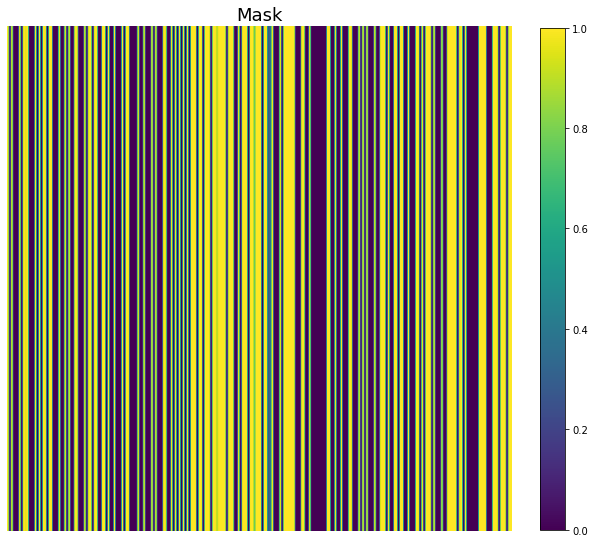

In [ ]:
print(temperature)
print(f"weight sum is {sum_w_prime(column_weights, temperature).numpy()}")
visualize_physical_layer(temperature)

566.5


Text(0.5, 1.0, 'Post-transform')

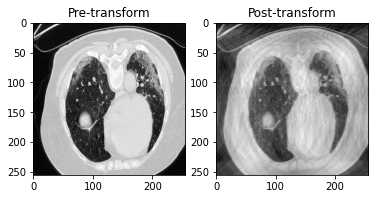

In [ ]:
print(temperature)
phys_layer_test = physical_layer(lung_train[0:25,:,:,:], temperature)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
axs[0].imshow(lung_train[10][:,:,0], cmap=plt.cm.gray)
axs[0].set_title("Pre-transform")
axs[1].imshow(phys_layer_test[10][:,:,0], cmap=plt.cm.gray)
axs[1].set_title("Post-transform")

# Visualize Test Results

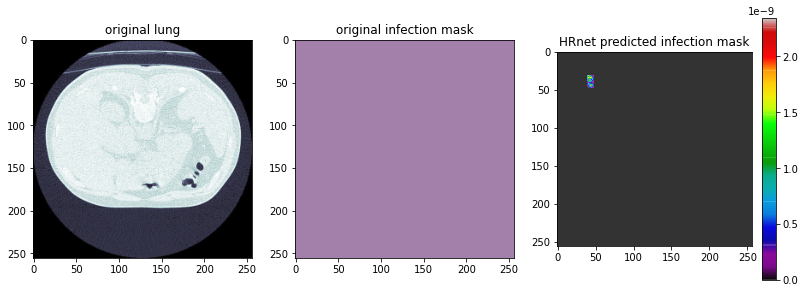

In [ ]:
import random

phys_layer_test = physical_layer(lung_test, temperature)


predicted_unet = unet_model.predict(phys_layer_test) 
predicted_hrnet = hrnet_model.predict(phys_layer_test)
fig = plt.figure(figsize = (18,15))



# to force it to pick a covid examplem leave while loop uncommented
number = random.randint(0, len(lung_test))
# while np.sum(infect_test[number][...,0])==0:
#     number = random.randint(0, len(lung_test))

# number=526


plt.subplot(1,4,1)
plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,4,2)
#plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.imshow(infect_test[number][...,0],alpha = 0.5)
plt.title('original infection mask')

plt.subplot(1,4,3)
# plt.imshow(lung_test[number][...,0], cmap = 'bone')
# a=plt.imshow(predicted_unet[number][...,0],alpha = 0.8,cmap = "nipy_spectral")
# plt.title('Unet predicted infection mask')

# plt.subplot(1,4,4)
#plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.imshow(predicted_hrnet[number][...,0],alpha = 0.8,cmap = "nipy_spectral")
plt.title('HRnet predicted infection mask')
plt.colorbar(fraction=0.06, pad=0.05)



In [ ]:
print(number)

526


Text(0.5, 1.0, 'Post-transform')

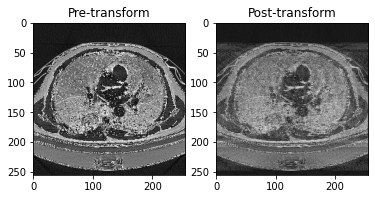

In [ ]:
phys_layer_test = physical_layer(lung_train[0:25,:,:,:], temperature)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
axs[0].imshow(lung_train[9][:,:,0], cmap=plt.cm.gray)
axs[0].set_title("Pre-transform")
axs[1].imshow(phys_layer_test[9][:,:,0], cmap=plt.cm.gray)
axs[1].set_title("Post-transform")

# Confusion Matrix Code

In [ ]:
import sklearn
def get_confusion_matrix_elements(groundtruth_image, predicted_image, threshold):

    threshold_image = predicted_image>threshold


    groundtruth_list = groundtruth_image.ravel()
    predicted_list = threshold_image.ravel()


    """returns confusion matrix elements i.e TN, FP, FN, TP as floats
    """
    all_sum = len(groundtruth_list)

    if np.sum(groundtruth_list)==all_sum and np.sum(predicted_list)==all_sum:
        tn, fp, fn, tp = 0, 0, 0, np.float64(len(groundtruth_list))

    elif np.sum(groundtruth_list)==0 and np.sum(predicted_list)==0:
        tn, fp, fn, tp = np.float64(len(groundtruth_list)), 0, 0, 0

    else:
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(groundtruth_list, predicted_list).ravel()
        tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

    return tn, fp, fn, tp


def batch_confusion_matrix_elements(infection_masks, predicted_masks, threshold):
    results = []

    for i in tqdm_notebook(range(len(predicted_masks))):
        results.append(get_confusion_matrix_elements(infection_masks[i], predicted_masks[i], threshold))
    
    return np.sum(results, axis=0)


def report_classification_results(tn, fp, fn, tp):
    recall_covid = recall_value(tn, fp, fn, tp)
    precision_covid = precision_value(tn, fp, fn, tp)
    f1_score_covid = 1/(1/recall_covid + 1/precision_covid)

    recall_healthy = recall_value(tp, fn, fp, tn) # swap what the positive class is
    precision_healthy = precision_value(tp, fn, fp, tn)
    f1_score_healthy = 1/(1/recall_healthy + 1/precision_healthy)

    IOU_score = iou_value(tn, fp, fn, tp)
    dice_score = dice_value(tn, fp, fn, tp)


    print("Classification Report")
    print("--------------------------------")
    print(f"Covid Recall: {recall_covid*100}%")
    print(f"Covid Precision: {precision_covid*100}%")
    print(f"Covid F1: {f1_score_covid*100}%")
    print(f"Healthy Recall: {recall_healthy*100}%")
    print(f"Healthy Recall: {precision_healthy*100}%")
    print(f"Healthy F1: {f1_score_healthy*100}%")
    print("Segmentation metrics")
    print("---------------------------------")
    print(f"IOU value: {IOU_score}")
    print(f"Dice Score: {dice_score}")
    print("---------------------------------")



def confusion_matrix_plot_hacky(tn, fp, fn, tp):
    fake_label=np.zeros(int(tn))
    fake_predict = np.zeros(int(tn))

    fake_label = np.append(fake_label, np.zeros(int(fp)))
    fake_predict = np.append(fake_predict, np.ones(int(fp)))

    fake_label = np.append(fake_label, np.ones(int(fn)))
    fake_predict = np.append(fake_predict, np.zeros(int(fn)))

    fake_label = np.append(fake_label, np.ones(int(tp)))
    fake_predict = np.append(fake_predict, np.ones(int(tp)))

    print("Printing Classification Report")

    from sklearn.metrics import classification_report, confusion_matrix
    target_names = ['No Covid', 'Covid']
    report_classification_results(tn, fp, fn, tp)


    print("Printing Confusion Matrix")

    import seaborn as sns

    cm = confusion_matrix(fake_label, fake_predict)

    print(cm)
    ax= plt.subplot(1,1,1)
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['No Covid', 'Infected']); ax.yaxis.set_ticklabels(['No Covid', 'Infected']);


def iou_value(tn, fp, fn, tp):
    # IOU = true_positive / (true_positive + false_positive + false_negative)
    return tp / (tp + fp + fn)

def dice_value(tn, fp, fn, tp):
    # IOU = 2*true_positive / (2*true_positive + false_positive + false_negative)
    return 2*tp / (2*tp + fp + fn)

def precision_value(tn, fp, fn, tp):
    return tp / (tp + fp)

def recall_value(tn, fp, fn, tp):
    return tp / (tp + fn)


def plot_iou_chart(infection_masks, predicted_masks, thresholds):
    results = []
    precisions = []
    recalls = []
    for thresh in thresholds:
        tn, fp, fn, tp = batch_confusion_matrix_elements(infection_masks, predicted_masks, thresh)
        results.append(iou_value(tn, fp, fn, tp))
        precisions.append(precision_value(tn, fp, fn, tp))
        recalls.append(recall_value(tn, fp, fn, tp))
    
    plt.plot(thresholds, results)
    plt.xlabel("Threshold")
    plt.ylabel("IOU Value")
    plt.show()
    
    print("The results are as follows")
    print(f"IOU: {results}")
    print(f"Precision: {precisions}")
    print(f"Recall: {recalls}")
    print(f"Thresholds: {thresholds}")


(64765.0, 167.0, 591.0, 13.0)
(62502.0, 2430.0, 518.0, 86.0)


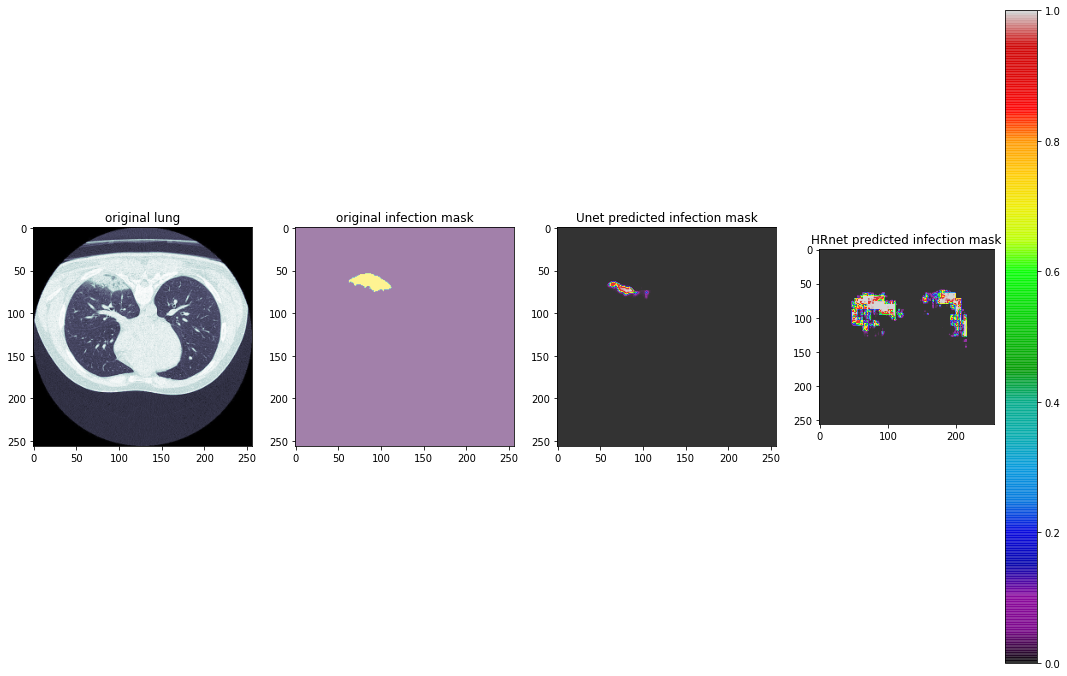

In [ ]:
lung_test_phys = physical_layer(lung_test, temperature)

predicted_unet = unet_model.predict(lung_test_phys)
predicted_hrnet = hrnet_model.predict(lung_test_phys)
fig = plt.figure(figsize = (18,12))


# force it to pick a covid example
number = random.randint(0, len(lung_test))
while np.sum(infect_test[number][...,0])==0:
    number = random.randint(0, len(lung_test))

plt.subplot(1,4,1)
plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,4,2)
#plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.imshow(infect_test[number][...,0],alpha = 0.5)
plt.title('original infection mask')

plt.subplot(1,4,3)
# plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.imshow(predicted_unet[number][...,0],alpha = 0.8,cmap = "nipy_spectral")
plt.title('Unet predicted infection mask')

plt.subplot(1,4,4)
# plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.imshow(predicted_hrnet[number][...,0],alpha = 0.8,cmap = "nipy_spectral")
plt.title('HRnet predicted infection mask')
plt.colorbar()

print(get_confusion_matrix_elements(infect_test[number], predicted_unet[number], threshold = 0.5))
print(get_confusion_matrix_elements(infect_test[number], predicted_hrnet[number], threshold = 0.5))

## Make sure to change the Threshold value to see how it changes the results


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Printing Classification Report
Classification Report
--------------------------------
Covid Recall: 13.831128779725265%
Covid Precision: 64.63840166182358%
Covid F1: 11.393238273118476%
Healthy Recall: 99.93355890837863%
Healthy Recall: 99.2485483034917%
Healthy F1: 49.79493784503434%
Segmentation metrics
---------------------------------
IOU value: 0.12858204104373666
Dice Score: 0.22786476546236947
---------------------------------
Printing Confusion Matrix
[[45575512    30301]
 [  345071    55388]]


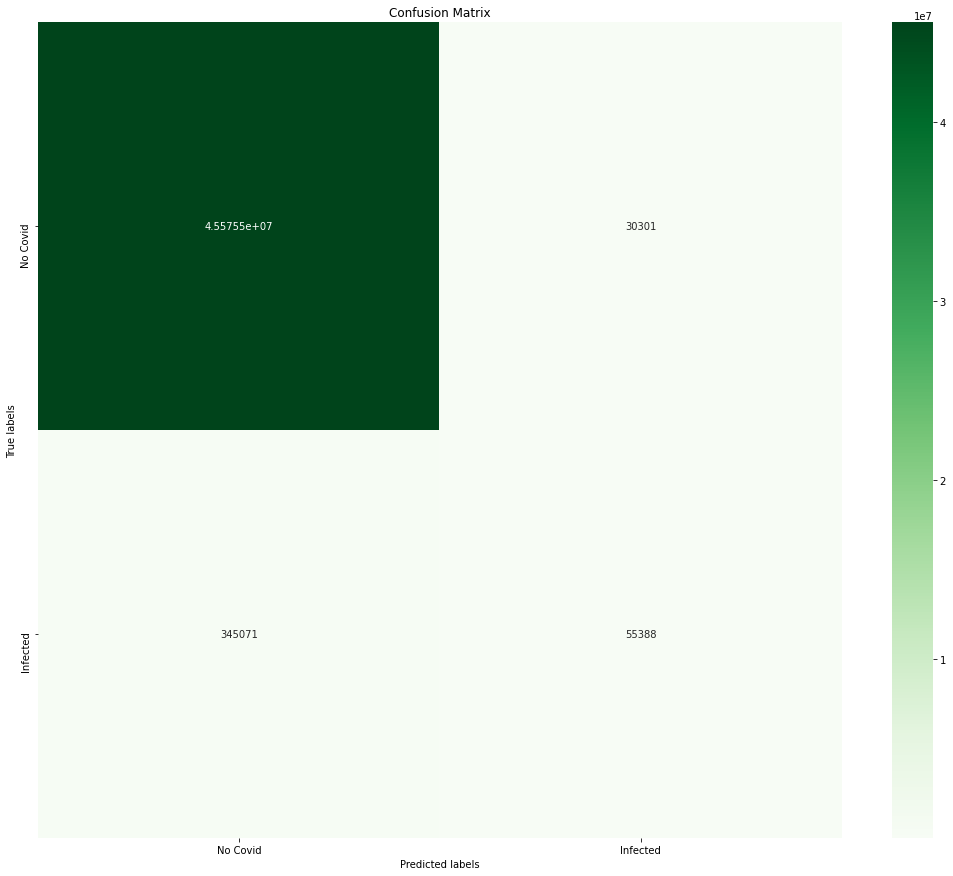

In [ ]:
tn_u, fp_u, fn_u, tp_u = batch_confusion_matrix_elements(infect_test, predicted_unet, threshold=0.2)
#tn_hr, fp_hr, fn_hr, tp_hr = batch_confusion_matrix_elements(infect_test, predicted_hrnet, threshold=0.2)

fig = plt.figure(figsize = (18,15))
plt.subplot(1,2,1)
confusion_matrix_plot_hacky(tn_u, fp_u, fn_u, tp_u)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Printing Classification Report
Classification Report
--------------------------------
Covid Recall: 10.787621204667644%
Covid Precision: 35.86609989373007%
Covid F1: 8.293227005972275%
Healthy Recall: 99.83061808370788%
Healthy Recall: 99.22141749050861%
Healthy F1: 49.76254277754371%
Segmentation metrics
---------------------------------
IOU value: 0.09043200120576002
Dice Score: 0.1658645401194455
---------------------------------
Printing Confusion Matrix
[[45528565    77248]
 [  357259    43200]]


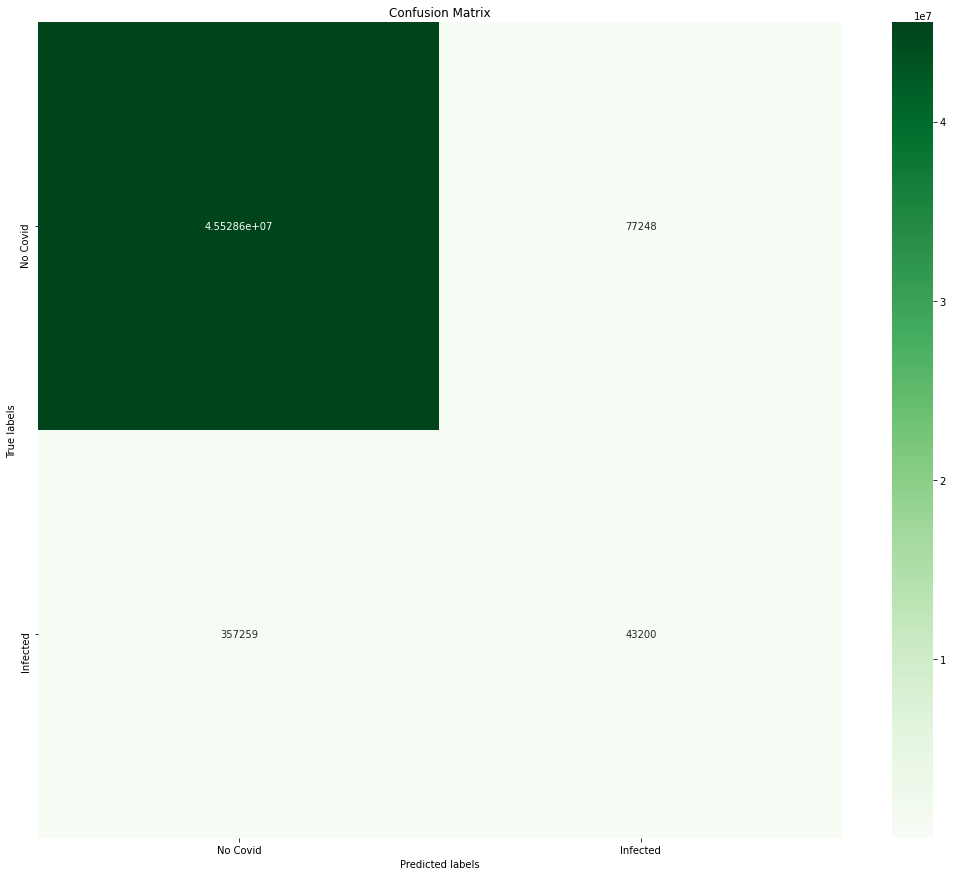

In [ ]:
tn_hr, fp_hr, fn_hr, tp_hr = batch_confusion_matrix_elements(infect_test, predicted_hrnet, threshold=0.2)

fig = plt.figure(figsize = (18,15))
plt.subplot(1,2,1)
confusion_matrix_plot_hacky(tn_hr, fp_hr, fn_hr, tp_hr)

## IOU Graphs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


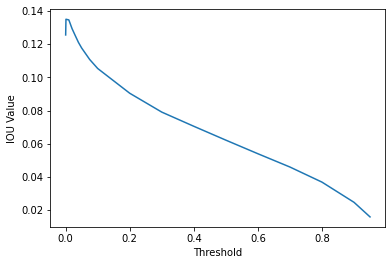

The results are as follows
IOU: [0.1255935316413143, 0.1350620645700319, 0.1346545355482584, 0.12940970335672744, 0.12520239644154485, 0.12108601566469836, 0.11771332120498881, 0.1108005255033089, 0.10536675973411526, 0.09043200120576002, 0.07906154727893602, 0.07050891360658236, 0.06214744881139885, 0.05395162812812463, 0.04593543377546938, 0.036828957797900706, 0.024653113435080216, 0.015846137919815435]
Precision: [0.15010536008663325, 0.18602603132086726, 0.24566321077383496, 0.2664493281260343, 0.27968433465364495, 0.2887122110997844, 0.29642921877832157, 0.31125042358522537, 0.32354242395255406, 0.35866099893730075, 0.3830883595201892, 0.4071184598664804, 0.4274848828420257, 0.44739080015461924, 0.4691035683202785, 0.49137931034482757, 0.5236984028209914, 0.5502396439575488]
Recall: [0.4347436316826442, 0.33020608851343086, 0.22957905803090953, 0.20103181599115016, 0.18478795582069577, 0.17256448225661053, 0.16335255294549506, 0.14679155668869973, 0.1351374297993053, 0.1078762120

In [ ]:
#plot_iou_chart(infect_test, predicted_unet, thresholds=[0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
plot_iou_chart(infect_test, predicted_hrnet, thresholds=[0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])

